# Path Tracing Notebook
The first 5 code cells are required only on Google Colab. Ignore them if you are running the notebook from your local machine.

In [1]:
# 1. Run only if you need to delete cached folder from Google Colab
# !rm -rf /content/light-transport

In [2]:
# 2. Download the project files from Github
# !git clone https://github.com/dipanjan92/light-transport.git

In [3]:
# 3. Add the project directory to the system PATH
# import sys
# sys.path.insert(0,'/content/light-transport/LightTransportSimulator')

In [4]:
# 4. PyVista is used to generate 3D objects
# !pip install pyvista

In [5]:
# 5. Switch to project directory
import os
os.chdir('G:/My Drive/Projects/light-transport/')
os.getcwd()

'G:\\My Drive\\Projects\\light-transport'

********************************************************************************************

In [6]:
import time
import matplotlib.pyplot as plt
import numpy as np
import numba

In [7]:
from LightTransportSimulator.light_transport.src.primitives import Sphere
from LightTransportSimulator.light_transport.src.cornell_box import get_cornell_sphere_box, get_cornell_box
from LightTransportSimulator.light_transport.src.constants import *
from LightTransportSimulator.light_transport.src.material import Material
from LightTransportSimulator.light_transport.src.vectors import normalize

In [8]:
WHITE_COLOR = Color(ambient=np.array([1, 1, 1], dtype=np.float64),
                    diffuse=np.array([1, 1, 1], dtype=np.float64),
                    specular=np.array([1, 1, 1], dtype=np.float64))

NO_COLOR = Color(ambient=np.array([0, 0, 0], dtype=np.float64),
                 diffuse=np.array([0, 0, 0], dtype=np.float64),
                 specular=np.array([0, 0, 0], dtype=np.float64))


RED_COLOR = Color(ambient=np.array([.75, .25, .25], dtype=np.float64),
                  diffuse=np.array([.75, .25, .25], dtype=np.float64),
                  specular=np.array([.75, .25, .25], dtype=np.float64))

GREEN_COLOR = Color(ambient=np.array([.25, .75, .25], dtype=np.float64),
                  diffuse=np.array([.25, .75, .25], dtype=np.float64),
                  specular=np.array([.25, .75, .25], dtype=np.float64))

BLUE_COLOR = Color(ambient=np.array([.25, .25, .75], dtype=np.float64),
                   diffuse=np.array([.25, .25, .75], dtype=np.float64),
                   specular=np.array([.25, .25, .75], dtype=np.float64))

GRAY_COLOR = Color(ambient=np.array([.75, .75, .75], dtype=np.float64),
                   diffuse=np.array([.75, .75, .75], dtype=np.float64),
                   specular=np.array([.75, .75, .75], dtype=np.float64))

GRAY_COLOR2 = Color(ambient=np.array([.25, .25, .25], dtype=np.float64),
                   diffuse=np.array([.25, .25, .25], dtype=np.float64),
                   specular=np.array([.25, .25, .25], dtype=np.float64))

GLASS_COLOR = Color(ambient=np.array([.999, .999, .999], dtype=np.float64),
                    diffuse=np.array([.999, .999, .999], dtype=np.float64),
                    specular=np.array([.999, .999, .999], dtype=np.float64))

In [9]:
from LightTransportSimulator.light_transport.src.scene import Light
from LightTransportSimulator.light_transport.src.light_samples import generate_area_light_samples

# # Create a global light source

source_mat = Material(color=WHITE_COLOR, shininess=1, ior=1.5, type=MatType.NONE.value, emission=12)
light_sphere = Sphere(center=np.array([50, 681.6-.27, 81.6], dtype=np.float64), radius=600, material=source_mat)

# Light source within Cornell Box is a spherical cap

# hypotenuse = radius of the light sphere, light_disk_radius = radius of the base of the cap
# https://mathworld.wolfram.com/SphericalCap.html
cornell_box_top_y = 81.6

_h = cornell_box_top_y - (light_sphere.center[1] - light_sphere.radius) # height of sphere cap

light_disk_radius = np.sqrt(_h*(2*light_sphere.radius-_h))

light_area = 2 * np.pi * light_sphere.radius * _h

light_disk_center = np.array([50, cornell_box_top_y-_h, 81.6], dtype=np.float64)

light_normal = normalize(light_disk_center - light_sphere.center)

light_samples_n = 100

lights = numba.typed.List()

for i in range(light_samples_n):
    sampled_source = light_sphere.center
    sampled_light = Light(sampled_source, light_sphere.material, light_normal, light_area)
    lights.append(sampled_light)

_h, light_disk_center, light_disk_radius

(0.2699999999999534, array([50.  , 81.33, 81.6 ]), 17.99797488607938)

In [10]:
lights[0].source

array([ 50.  , 681.33,  81.6 ])

In [11]:
from LightTransportSimulator.light_transport.src.scene import Camera, SphereScene

# Setup scene

# point camera
camera_pos = np.array([50, 52, 295.6], dtype=np.float64)
camera = Camera(camera_pos)

# screen 16:9
width=256
height=192
# width = 1024
# height = 768

# max_depth is the conventional term used in rendering to denote
# the maximum number of times a ray can bounce within the scene
max_depth=8
# number of samples per pixel
n_samples = 25

# Initialise the scene with lights and camera
scene = SphereScene(camera=camera, lights=lights, width=width, height=height, max_depth=max_depth, f_distance=1, number_of_samples=n_samples//4)

In [12]:
# update the transformation matrix
# It's updated outside __init__ as numba giving compile time errors

# T = scene.t_matrix
# T[:3, 3] = camera.position
# T[:3, :3] = np.linalg.inv(np.array([normalize(np.cross(camera.look_at, camera.scene_normal)), camera.look_at, normalize(np.cross(camera.look_at, normalize(np.cross(camera.look_at, camera.scene_normal))))]))

T = np.array([
    [1, 0, 0, 50],
    [0, 1, 0, 40.8],
    [0, 0, 1, 81.6],
    [0, 0, 0, 1]
], dtype=np.float64)

scene.t_matrix = T
scene.t_matrix

array([[ 1. ,  0. ,  0. , 50. ],
       [ 0. ,  1. ,  0. , 40.8],
       [ 0. ,  0. ,  1. , 81.6],
       [ 0. ,  0. ,  0. ,  1. ]])

In [13]:
# Set wall colors and materials for the Cornell box

surface_mat = Material(color=BLUE_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)
left_wall_mat = Material(color=RED_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)
right_wall_mat = Material(color=RED_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)
front_wall_mat = Material(color=BLUE_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)

# Get the triangles required to render the Cornell box
spheres = get_cornell_sphere_box(scene, surface_mat, left_wall_mat, right_wall_mat, front_wall_mat)

In [14]:
spheres.append(light_sphere)

In [15]:
# Add the triangles in the list of objects
PLASTIC = Material(color=GREEN_COLOR, shininess=10, ior=1.460, type=MatType.SPECULAR.value, emission=0)
GLASS = Material(color=GLASS_COLOR, shininess=50, ior=1.500, type=MatType.SPECULAR.value, emission=0)
MIRROR = Material(color=GLASS_COLOR, shininess=50, ior=1.500, type=MatType.MIRROR.value, emission=0)
ALUMINUM = Material(color=GRAY_COLOR2, shininess=50, ior=1.400, type=MatType.SPECULAR.value, emission=0)

In [16]:
sphere_1 = Sphere(center=np.array([27, 16.5, 47], dtype=np.float64), radius=16.5, material=MIRROR)
spheres.append(sphere_1)
sphere_2 = Sphere(center=np.array([73, 16.5, 78], dtype=np.float64), radius=16.5, material=GLASS)
spheres.append(sphere_2)
# sphere_3 = Sphere(center=np.array([-0.3, 0, 0, 1], dtype=np.float64), radius=0.15, material=GLASS)
# objects.append(sphere_3)

In [17]:
triangles = numba.typed.List()

In [18]:
from LightTransportSimulator.light_transport.src.bvh_new import BoundedBox, BVHNode, build_bvh, LinearBVHNode, flatten_bvh, intersect_bvh

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = []
for i in range(len(triangles)):
    bounded_boxes.append(BoundedBox(triangles[i], i))

len(triangles), len(bounded_boxes)

(0, 0)

In [19]:
if len(triangles)>0:
    # Initialise a bounding volume hierarchy tree
    start = 0
    end = len(bounded_boxes)
    ordered_prims = []
    total_nodes = 0
    root, bounded_boxes, ordered_prims, total_nodes = build_bvh(triangles, bounded_boxes, start, end, ordered_prims, total_nodes)
    # swap the primitives array with the ordered list
    primitives = ordered_prims


    # create a linear representation of the bvh tree
    linear_nodes = numba.typed.List()
    for _ in range(total_nodes):
        linear_nodes.append(LinearBVHNode())


    # linear bvh
    linear_bvh, off_set = flatten_bvh(linear_nodes, root, 0)
    # len(linear_bvh)

    # check if indexes of all primitives present in the linear bvh tree
    total = 0
    for _bvh in linear_bvh:
        total+= _bvh.n_primitives
    print(total==len(triangles)) # should be equal to the number of primitives
else:
    linear_bvh = None
    triangles = None

In [20]:
from LightTransportSimulator.light_transport.src.global_illumination import render_scene
# from LightTransportSimulator.light_transport.src.render_old import render_scene

start = time.time()
# primitives = spheres, triangles
image = render_scene(scene, spheres, triangles, linear_bvh)
image = np.flipud(image) # flipped
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

G:\My Drive\Projects\light-transport\LightTransportSimulator\light_transport\src\global_illumination.py:149: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  color = color + trace_path(scene, spheres, triangles, bvh, cam_ray, 0)
G:\My Drive\Projects\light-transport\LightTransportSimulator\light_transport\src\global_illumination.py:149: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  color = color + trace_path(scene, spheres, triangles, bvh, cam_ray, 0)
G:\My Drive\Projects\light-transport\LightTransportSimulator\light_transport\src\global_illumination.py:149: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  color = color + trace_path(scene, spheres, triangles, bvh, cam_ray, 0)
G:\My Drive\Projects\light-transport\LightTransportSimulator\light_transport\src\glob

0.050.261780104712045

87.95811518324608
62.82722513089005
75.39267015706807
56.544502617801044
25.130890052356023
94.24083769633508
37.696335078534034
31.413612565445025
12.565445026178011
18.848167539267017
69.10994764397905
43.97905759162304
6.282722513089006
81.67539267015707
31.93717277486911
13.089005235602095
19.3717277486911
75.91623036649214
38.21989528795812
25.654450261780106
88.48167539267016
50.78534031413613
57.068062827225134
94.76439790575917
0.5235602094240838
63.35078534031414
82.19895287958116
44.50261780104712
6.806282722513089
69.63350785340315
32.460732984293195
19.895287958115183
13.612565445026178
76.43979057591623
26.17801047120419
38.7434554973822
89.00523560209425
1.0471204188481675
51.30890052356021
57.59162303664922
82.72251308900523
63.87434554973822
95.28795811518324
7.329842931937173
45.026178010471206
70.15706806282722
20.418848167539267
32.98429319371728
14.136125654450261
76.96335078534031
26.701570680628272
39.26701570680628
83.24607329842932
1.57068

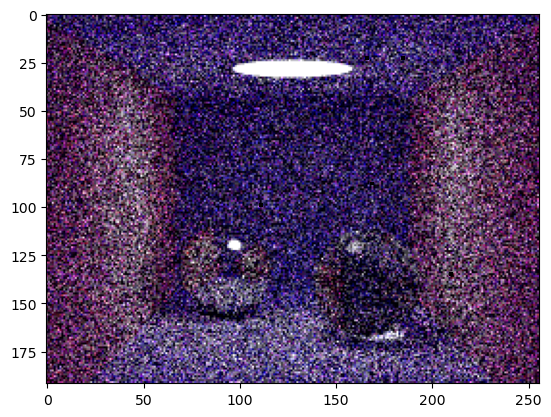

In [21]:
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


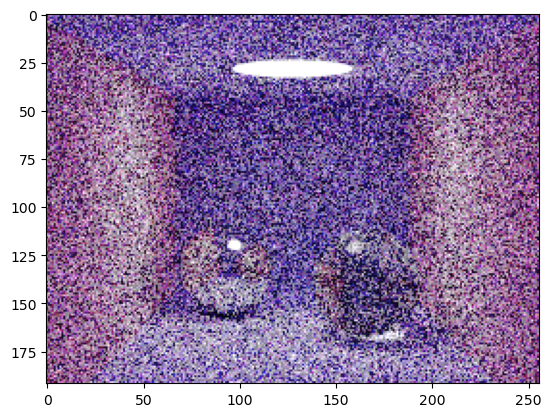

In [22]:
# gamma correction
img_corrected = np.clip(255.0 * np.power(image, 1.0 / 2.2), a_min=0.0, a_max=255.0).astype(int)
plt.imshow(img_corrected)